In [1]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"

import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
%matplotlib inline
import sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../'))
import functools

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put
from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
# from desc.boundary_conditions import get_boundary_condition, LCFSConstraint
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison
from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.profiles import SplineProfile
from desc.magnetic_fields import SplineMagneticField

from desc.utils import flatten_list
os.getcwd()

DESC version 0.4.13+610.g5905668.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 21.19 GB available memory


'/home/fouriest/SCHOOL/Princeton/PPPL/DESC_freeb'

In [2]:
eq = load("freeb_test_out.h5")

/home/fouriest/SCHOOL/Princeton/PPPL/DESC_freeb/desc/io/hdf5_io.py:119: RuntimeWarning: Could not load attribute '_name', no class name found.
  warnings.warn(


(<Figure size 1152x960 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

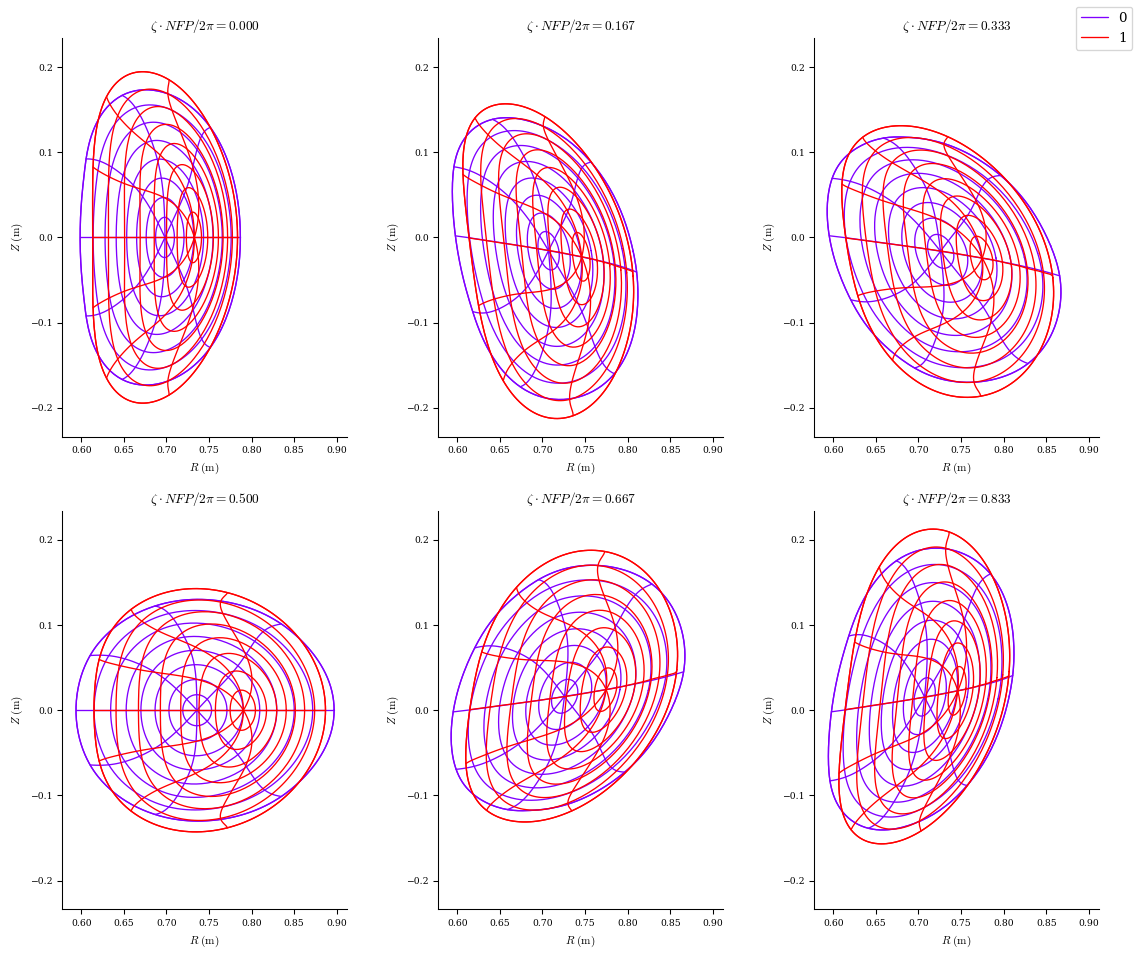

In [9]:
plot_comparison([eq, veq])

In [5]:
from desc.objectives.objective_funs import _Objective
from desc.compute import compute_contravariant_basis, compute_contravariant_magnetic_field, compute_pressure
from desc.utils import unpack_state
from desc.geometry.utils import rpz2xyz, rpz2xyz_vec, xyz2rpz_vec, rotation_matrix

@jax.jit  
def biot_loop(re, rs, J, dV):
    """
    
    Parameters
    ----------
    re : ndarray, shape(n_eval_pts, 3)
        evaluation points
    rs : ndarray, shape(n_src_pts, 3)
        source points
    J : ndarray, shape(n_src_pts, 3)
        current density vector at source points
    dV : ndarray, shape(n_src_pts)
        volume element at source points
    """
    re, rs, J, dV = map(jnp.asarray, (re, rs, J, dV))
    assert J.shape == rs.shape
    JdV = J * dV[:, None]
    B = jnp.zeros_like(re)
    def body(i, B):
        r = re - rs[i,:]
        num = jnp.cross(JdV[i,:], r, axis=-1)
        den = jnp.linalg.norm(r, axis=-1)**3
        B = B + jnp.where(den[:,None]==0, 0, num/den[:,None])
        return B
    return 1e-7 * jax.lax.fori_loop(0, J.shape[0], body, B)

@jax.jit
def biot_loop_periods(re, rs, J, dV, NFP):
    
    dphi = 2*np.pi/NFP
    R = rotation_matrix([0,0,1], dphi)
    B = jnp.zeros_like(re)
    Ri = jnp.eye(3)
    def body(i, B_Ri):
        B, Ri = B_Ri
        rsi = (Ri @ rs.T).T
        Ji = (Ri @ J.T).T
        B = B + biot_loop(re, rsi, Ji, dV)
        Ri = R @ Ri
        return B, Ri
    return jax.lax.fori_loop(0, NFP, body, (B,Ri))[0]

class BoundaryErrorBS(_Objective):

    _scalar = False
    _linear = False
    
    def __init__(self, ext_field, eq=None, target=0, weight=1, sgrid=None, egrid=None, name="B^2 Boundary"): 
        super().__init__(eq, target, weight, name)
        self.ext_field = ext_field
        self.sgrid=sgrid
        self.egrid=egrid
        self._callback_fmt = "Boundary Pressure Imbalance: {:10.3e} " + "Pa"
        
    def build(self, eq, use_jit=True, verbose=1):
        
        ntheta = 4*eq.M_grid+1
        nzeta = 4*eq.N_grid+1
        if self.egrid is None:
            self.egrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 
            self.egrid.nodes += np.array([0, np.pi/ntheta, np.pi/nzeta/eq.NFP])
        if self.sgrid is None:
            self.sgrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 

        self._dim_f = 2 * self.egrid.num_nodes
        self.NFP = eq.NFP
            
        self.eR_transform = Transform(self.egrid, eq.R_basis, derivs=1)
        self.eZ_transform = Transform(self.egrid, eq.Z_basis, derivs=1)
        self.eL_transform = Transform(self.egrid, eq.L_basis, derivs=1)

        self.sR_transform = Transform(self.sgrid, eq.R_basis, derivs=1)
        self.sZ_transform = Transform(self.sgrid, eq.Z_basis, derivs=1)
        self.sL_transform = Transform(self.sgrid, eq.L_basis, derivs=1)

        self.K_transform = Transform(self.sgrid, eq.K_basis, derivs=1)

        self.ep_profile = eq.pressure.copy()
        self.ei_profile = eq.iota.copy()
        self.sp_profile = eq.pressure.copy()
        self.si_profile = eq.iota.copy()
        self.ep_profile.grid = self.egrid
        self.ei_profile.grid = self.egrid
        self.sp_profile.grid = self.sgrid
        self.si_profile.grid = self.sgrid        
    
        self._check_dimensions()
        self._set_dimensions(eq)
        self._set_derivatives(use_jit=use_jit)
        self._built = True
    
    def compute(self, R_lmn, Z_lmn, L_lmn, p_l, i_l, Psi, IGphi_mn):

        Bdata_src = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, self.sR_transform, self.sZ_transform, 
                                   self.sL_transform, self.si_profile)
        ndata_src = compute_contravariant_basis(R_lmn, Z_lmn, self.sR_transform, self.sZ_transform)
        Bdata_eval = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, self.eR_transform, self.eZ_transform, 
                                   self.eL_transform, self.ei_profile)
        ndata_eval = compute_contravariant_basis(R_lmn, Z_lmn, self.eR_transform, self.eZ_transform)
        pdata_eval = compute_pressure(p_l, self.ep_profile)


        I = IGphi_mn[0] / mu_0
        G = IGphi_mn[1] / mu_0
        phi_mn = IGphi_mn[2:] / mu_0

        K_t = self.K_transform.transform(phi_mn, dt=1)[:,np.newaxis] + I/(2*np.pi)
        K_z = self.K_transform.transform(phi_mn, dz=1)[:,np.newaxis] + G/(2*np.pi)
        K = K_t*ndata_src['e_theta'] + K_z*ndata_src['e_zeta']
        K = rpz2xyz_vec(K, phi=self.K_transform.grid.nodes[:,2])

        Bsrc = Bdata_src['B']
        Bsrc = rpz2xyz_vec(Bsrc, phi=self.sR_transform.grid.nodes[:,2])
        nsrc = ndata_src['e^rho'] / jnp.linalg.norm(ndata_src['e^rho'], axis=1)[:,np.newaxis]
        nsrc = rpz2xyz_vec(nsrc, phi=self.sR_transform.grid.nodes[:,2])
        J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0

        neval = ndata_eval['e^rho'] / jnp.linalg.norm(ndata_eval['e^rho'], axis=1)[:,np.newaxis]
        neval = rpz2xyz_vec(neval, phi=self.eR_transform.grid.nodes[:,2])

        rsrc = jnp.array([Bdata_src['R'], self.sR_transform.grid.nodes[:,2], Bdata_src['Z']]).T
        rsrc = rpz2xyz(rsrc)
        reval = jnp.array([Bdata_eval['R'], self.eR_transform.grid.nodes[:,2], Bdata_eval['Z']]).T
        reval = rpz2xyz(reval)

        dVeval = abs(Bdata_eval['|e_theta x e_zeta|'] * self.eR_transform.grid.weights)  # TODO: change to spacing
        dVsrc = abs(Bdata_src['|e_theta x e_zeta|'] * self.sR_transform.grid.weights)  # TODO: change to spacing
        
        B_tot = rpz2xyz_vec(Bdata_eval['B'], phi=self.eR_transform.grid.nodes[:,2])
        B_plasma = biot_loop_periods(reval, rsrc, J, dVsrc/self.NFP, self.NFP) + B_tot/2
        B_sheet = biot_loop_periods(reval, rsrc, K, dVsrc/self.NFP, self.NFP)
        B_ex = self.ext_field.compute_magnetic_field(reval, basis="xyz")
        B_in = B_tot 
        B_out = B_ex + B_plasma + B_sheet
        Bsq_in = jnp.sum(B_in**2, axis=-1) + 2*mu_0*pdata_eval['p']
        Bsq_out = jnp.sum(B_out**2, axis=-1)
        Bsq_diff = (Bsq_in - Bsq_out)*dVeval
        Bn = jnp.sum(B_out*neval, axis=-1)*dVeval
        return jnp.concatenate([Bsq_diff, Bn])
    


In [6]:
f = Dataset("../educational_VMEC/test/wout_test_beta.vmec.nc")
print(f['mpol'][:])
print(f['ntor'][:])

8
8


In [7]:
veq = VMECIO.load("../educational_VMEC/test/wout_test_beta.vmec.nc", spectral_indexing="fringe")
veq.change_resolution(L=16, M=8, N=8, L_grid=20, M_grid=12, N_grid=12)

pres = np.asarray(f.variables['presf'])
sp = np.linspace(0,1,pres.size)
rp = np.sqrt(sp)
pressure = SplineProfile(pres, rp)

iot = np.asarray(f.variables['iotaf'])
si = np.linspace(0,1,iot.size)
ri = np.sqrt(si)
iota = SplineProfile(iot, ri)


veq.pressure = pressure
veq.iota = iota



In [8]:
vacini = Dataset("../educational_VMEC/test/vac/vacin_test_beta.vmec_000000.nc", "r")

NFP     = int(vacini['nfp'][()])
mgrid = "tests/inputs/nestor/mgrid_test.nc"
extcur = vacini['extcur'][()]        
folder = os.getcwd()
mgridFilename = os.path.join(folder, mgrid)
ext_field = SplineMagneticField.from_mgrid(mgridFilename, extcur, extrap=True, period=(2*np.pi/NFP))


In [6]:
veq.resolution_summary()
veq.solve(ftol=1e-2, xtol=1e-6, gtol=1e-6, maxiter=1000, verbose=3);

Spectral indexing: fringe
Spectral resolution (L,M,N)=(16,8,8)
Node pattern: jacobi
Node resolution (L,M,N)=(20,12,12)
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 472 ms
Timer: Objecive build = 484 ms
Compiling objective function and derivatives
Timer: Objective compilation time = 6.80 sec
Timer: Jacobian compilation time = 16.0 sec
Timer: Total compilation time = 22.8 sec
Factorizing linear constraints
Timer: linear constraint factorize = 1.06 sec
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.6371e+06                                    1.86e+11    
       1              2         7.2053e+03      6.63e+06       6.61e-02       5.45e+09    
       2              3         3.4277e+03      3.78e+03       4.98e-02       3.29e+08    
       3              4         8.7807e+02      2.55e+03       4.51e-02       3.99e+08    
       4              6        

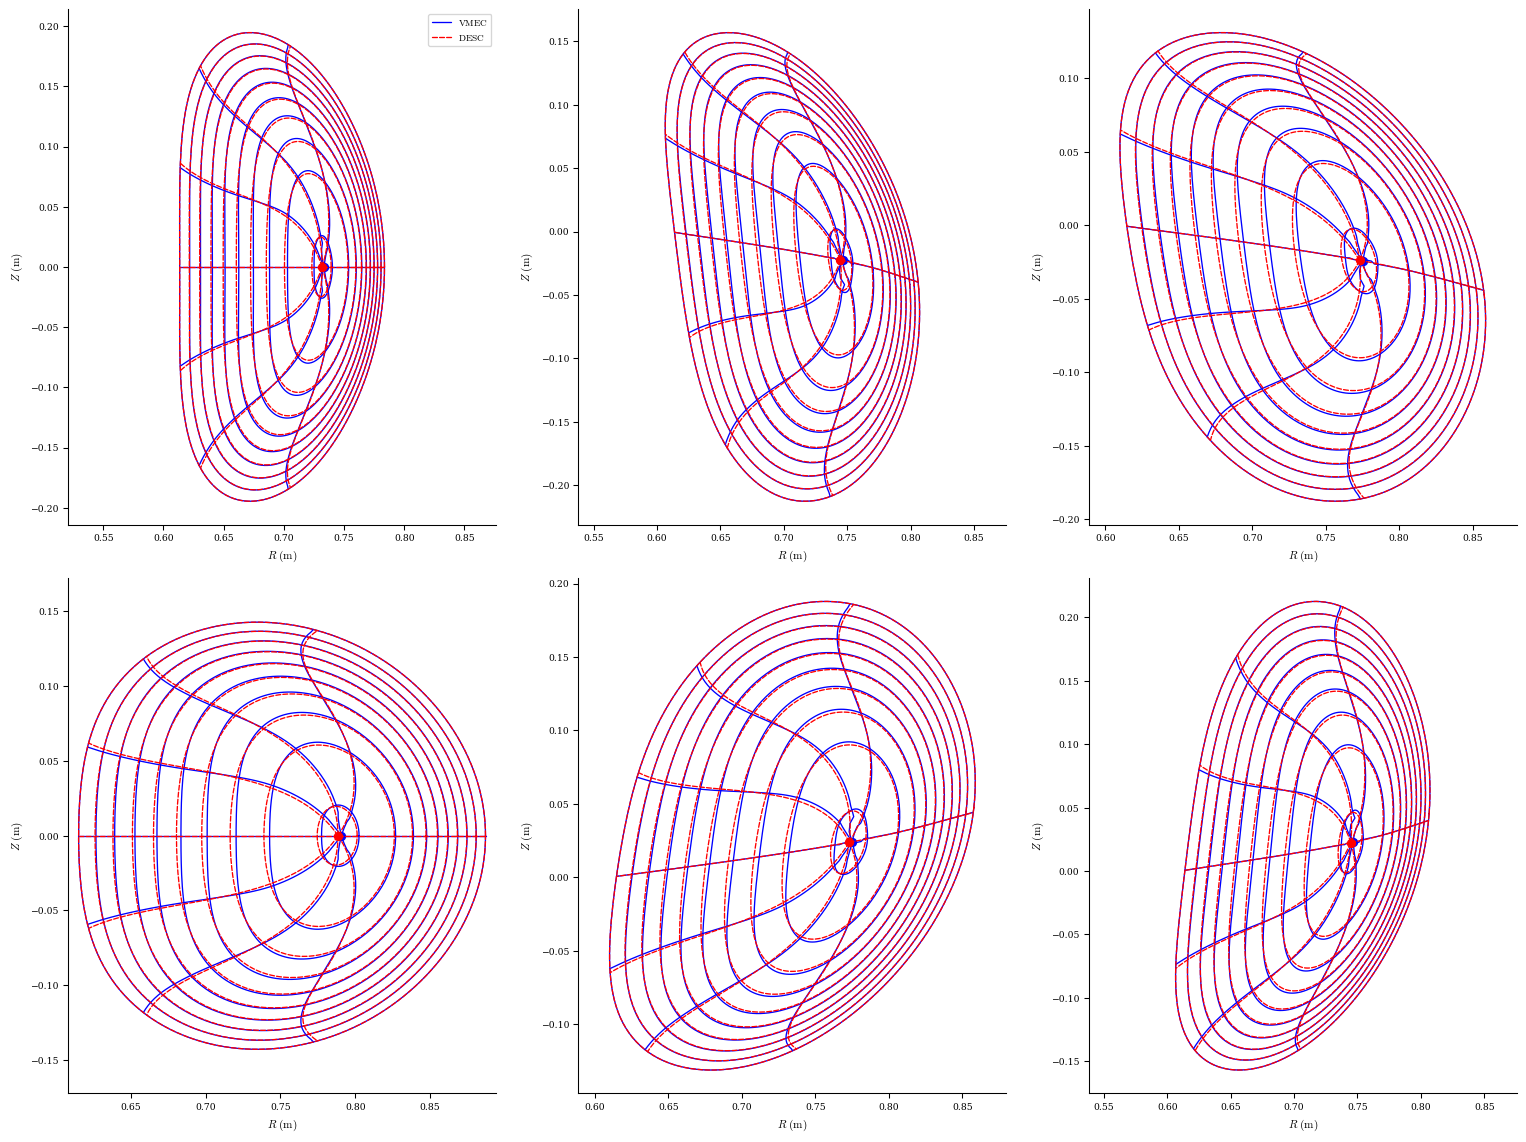

In [7]:
fig, ax = VMECIO.plot_vmec_comparison(veq, "../educational_VMEC/test/wout_test_beta.vmec.nc")

In [8]:
surf = veq.get_surface_at(1)
surf.change_resolution(M=1, N=0)
eq = Equilibrium(Psi=veq.Psi, pressure=veq.pressure, iota=veq.iota, spectral_indexing=veq.spectral_indexing, sym=veq.sym, NFP=veq.NFP)

In [9]:
surf.R_lmn

DeviceArray([0.71512541, 0.11141437], dtype=float64)

In [10]:
surf.Z_lmn = surf.R_lmn[-1:]

In [11]:
eq.set_initial_guess(surf)
eq.surface = surf


In [12]:
eq.change_resolution(veq.L, veq.M, veq.N, veq.L_grid, veq.M_grid, veq.N_grid)
eq.solve(ftol=1e-2, verbose=3);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 247 ms
Timer: Objecive build = 258 ms
Compiling objective function and derivatives
Timer: Objective compilation time = 6.84 sec
Timer: Jacobian compilation time = 16.2 sec
Timer: Total compilation time = 23.0 sec
Factorizing linear constraints
Timer: linear constraint factorize = 595 ms
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.8612e+06                                    2.30e+10    
       1              4         2.5963e+06      4.26e+06       2.56e-01       1.91e+10    
       2              5         7.0308e+04      2.53e+06       8.27e-02       5.47e+09    
       3              6         8.0695e+03      6.22e+04       7.84e-02       3.64e+09    
       4              8         3.2002e+03      4.87e+03       4.18e-02       6.35e+08    
       5              9         1.2933e+03      1.91e+03     

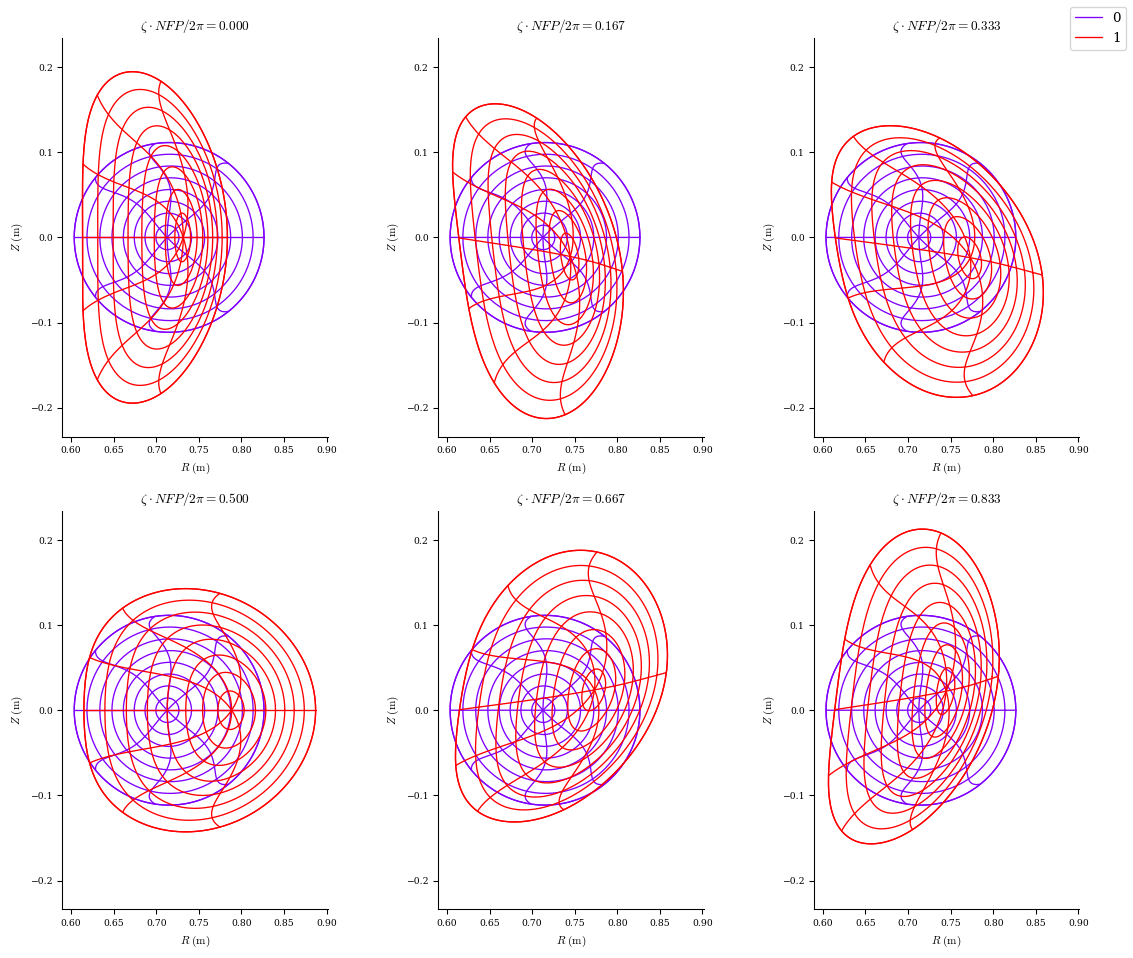

In [13]:
plot_comparison([eq, veq]);

In [14]:
# eq.K_basis = DoubleFourierSeries(eq.M, eq.N, eq.NFP, sym="sin")
# eq.IGphi_mn = jnp.zeros(eq.K_basis.num_modes+2)

In [15]:
from desc.objectives import ObjectiveFunction, ForceBalance, LambdaGauge, FixPressure, FixIota, FixPsi

bc_objective = BoundaryErrorBS(ext_field)
fb_objective = ForceBalance()

objective = ObjectiveFunction(bc_objective)
constraints = (fb_objective,
               FixPressure(),
               FixIota(),
               FixPsi(),
              )

fb_objective.build(eq)
bc_objective.build(eq)

Precomputing transforms


In [16]:
def print_error_summary(eqis):
    for eqi in eqis:
        f = fb_objective.callback(eqi.R_lmn, eqi.Z_lmn, eqi.L_lmn, eqi.p_l, eqi.i_l, eqi.Psi, eq.IGphi_mn)
        b = bc_objective.callback(eqi.R_lmn, eqi.Z_lmn, eqi.L_lmn, eqi.p_l, eqi.i_l, eqi.Psi, eq.IGphi_mn)
    

In [17]:
bc_objective.callback(eq.R_lmn, eq.Z_lmn, eq.L_lmn, eq.p_l, eq.i_l, eq.Psi, eq.IGphi_mn)
bc_objective.callback(veq.R_lmn, veq.Z_lmn, veq.L_lmn, veq.p_l, veq.i_l, veq.Psi, eq.IGphi_mn)

Boundary Pressure Imbalance:  2.658e-02 Pa
Boundary Pressure Imbalance:  5.393e-04 Pa


In [ ]:
eq1 = eq.copy()
eq1.optimize(objective, constraints, maxiter=40, verbose=3, 
             options={"perturb_options":{"order":2}, "initial_trust_radius":1e-3, "ga_tr_ratio":0});

Building objective: B^2 Boundary
Timer: Objecive build = 283 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 247 ms
Timer: Objecive build = 253 ms
Factorizing linear constraints
Timer: linear constraint factorize = 211 ms
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.5318e-04                                    2.09e-02    
       1              2         3.1143e-04      4.18e-05       4.95e-03       1.91e-02    
       2              3         2.3732e-04      7.41e-05       1.00e-02       1.58e-02    
       3              4         1.2360e-04      1.14e-04       2.05e-02       1.00e-02    
       4              5         1.6117e-05      1.07e-04       3.97e-02       1.95e-03    
       5              6         7.2203e-07      1.54e-05       4.68e-02       3.86e-04    
       6              8         3.7607e-07      3.46e-07       2.31e-02       2.9

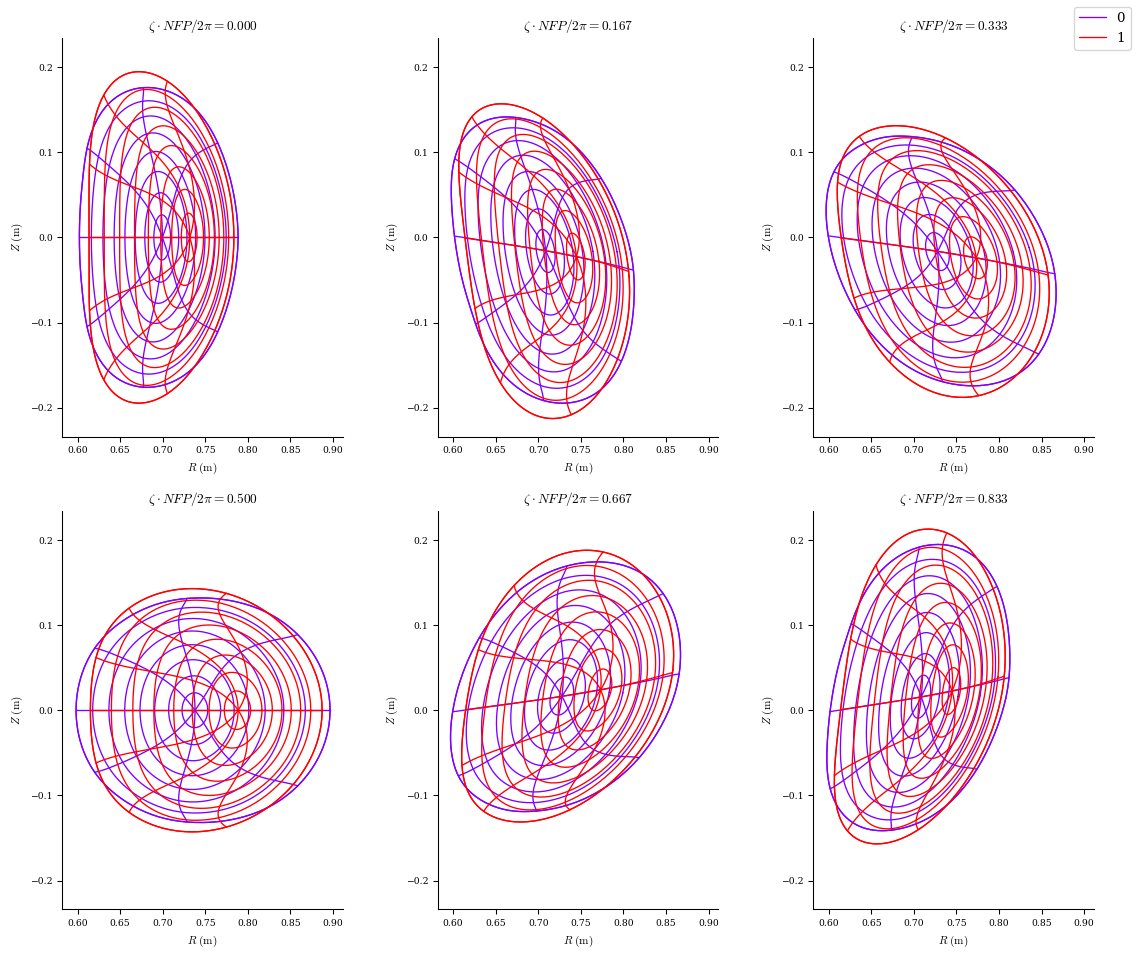

In [23]:
plot_comparison([eq1, veq]);

In [24]:
eq1.optimize(objective, constraints, maxiter=20, verbose=3, 
             options={"perturb_options":{"order":2}, "initial_trust_radius":1e-3, "ga_tr_ratio":0});

Building objective: B^2 Boundary
Timer: Objecive build = 262 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 250 ms
Timer: Objecive build = 256 ms
Factorizing linear constraints
Timer: linear constraint factorize = 13.0 ms
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4275e-08                                    3.14e-05    
       1              6         1.4275e-08      0.00e+00       0.00e+00       3.14e-05    
Optimization terminated successfully.
`xtol` condition satisfied.
         Current function value: 1.428e-08
         Iterations: 1
         Function evaluations: 6
         Jacobian evaluations: 1
Timer: Solution time = 21.7 min
Timer: Avg time per step = 21.7 min
Start of solver
Total (sum of squares):  1.428e-08, 
Boundary Pressure Imbalance:  1.690e-04 Pa
End of solver
Total (sum of squares):  1.458e-08, 
Boundary Pressure Imbalance:  1

In [16]:
eq1 = eq.copy()
eq2 = eq1._optimize(objective, ObjectiveFunction(fb_objective), maxiter=60, verbose=3, 
             perturb_options={"order":2, "dZb":True, "dRb":True, "tr_ratio":[0.01, 0.01]});

Building objective: B^2 Boundary
Building objective: force
Precomputing transforms
Total (sum of squares):  7.348e-04, 
Boundary Pressure Imbalance:  3.833e-02 Pa
Optimization Step 1
Trust-Region ratio = 1.000e-02
Perturbing Rb_lmn, Zb_lmn
Computing df
Computing dg
Factoring LHS
Computing d^2f
Computing d^2g
||dc||/||c|| =  1.010e-02
||dx||/||x|| =  1.009e-02
Compiling objective function and derivatives
Factorizing linear constraints
Starting optimization
         Current function value: 2.584e+00
         Iterations: 41
         Function evaluations: 50
         Jacobian evaluations: 42
Start of solver
Total (sum of squares):  7.364e+26, 
Total force:  3.838e+13 (N)
End of solver
Total (sum of squares):  2.584e+00, 
Total force:  2.273e+00 (N)
Total (sum of squares):  3.857e-04, 
Boundary Pressure Imbalance:  2.778e-02 Pa
Predicted Reduction =  3.718e-04
Reduction Ratio = +0.939
Timer: Step 1 time = 5.24 min
Optimization Step 2
Trust-Region ratio = 2.000e-02
Perturbing Rb_lmn, Zb_lmn


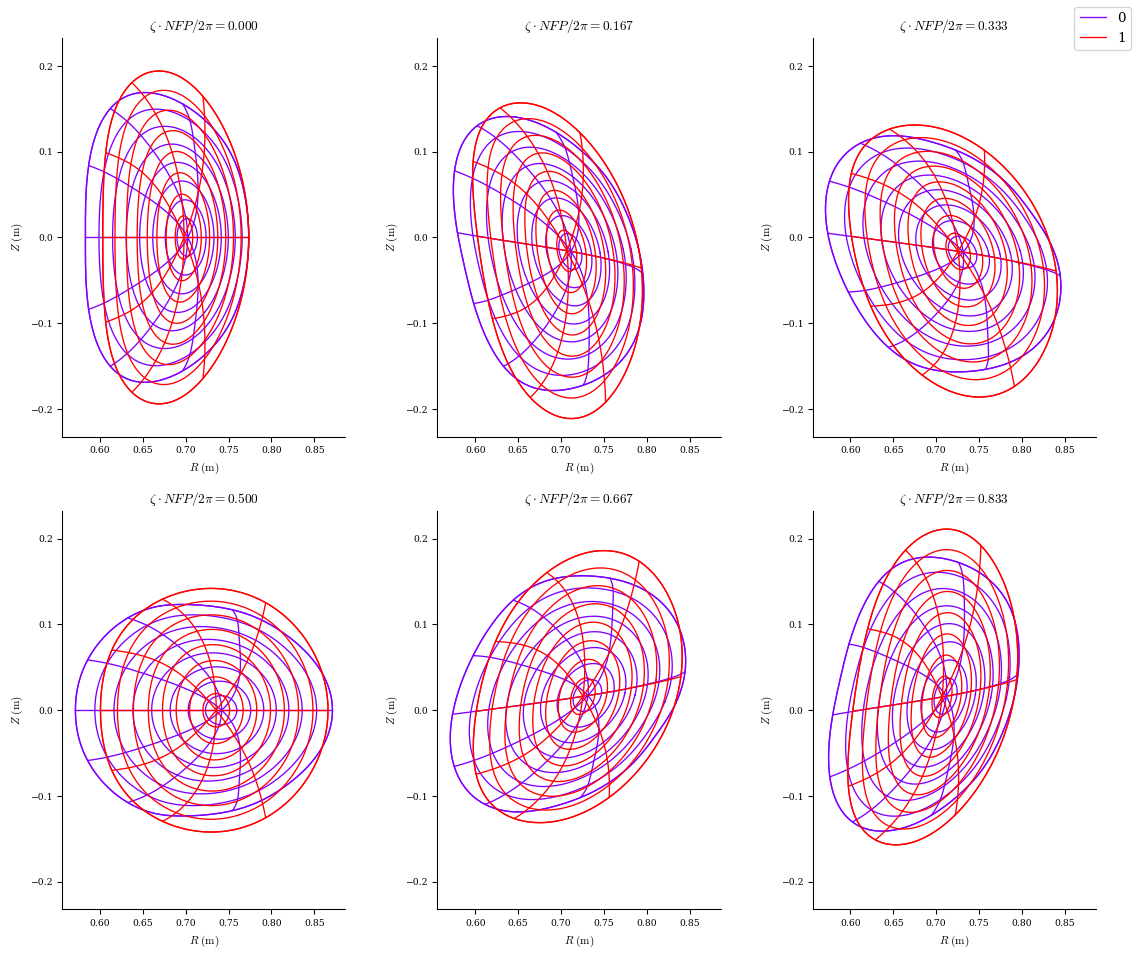

In [17]:
plot_comparison([eq2, veq]);

In [18]:
bc_objective1 = ObjectiveFunction(bc_objective)
fb_objective1 = ObjectiveFunction(fb_objective)

bc_objective1.build(eq)
fb_objective1.build(eq)

Building objective: B^2 Boundary
Building objective: force
Precomputing transforms


In [19]:
eqs = [eq]
from desc.perturbations import optimal_perturb
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

Perturbing Rb_lmn, Zb_lmn, IGphi_mn
Computing df
Timer: df computation = 33.8 sec
Computing dg
Timer: dg computation = 23.0 min
Factoring LHS
Timer: LHS factorization = 385 ms
Computing d^2f
Timer: d^2f computation = 37.5 sec
Computing d^2g
Timer: d^2g computation = 59.7 sec
||dc||/||c|| =  5.145e-02
||dx||/||x|| =  5.107e-02
Timer: Total perturbation = 26.0 min
Compiling objective function and derivatives
Factorizing linear constraints
Starting optimization
Optimization terminated successfully.
`xtol` condition satisfied.
         Current function value: 1.966e+10
         Iterations: 15
         Function evaluations: 32
         Jacobian evaluations: 16
Start of solver
Total (sum of squares):  9.262e+19, 
Total force:  1.361e+10 (N)
End of solver
Total (sum of squares):  1.966e+10, 
Total force:  1.983e+05 (N)


In [20]:
print_error_summary(eqs)

Total force:  8.009e+07 (N)
Boundary Pressure Imbalance:  2.658e-02 Pa
Total force:  1.517e+13 (N)
Boundary Pressure Imbalance:  8.457e+03 Pa


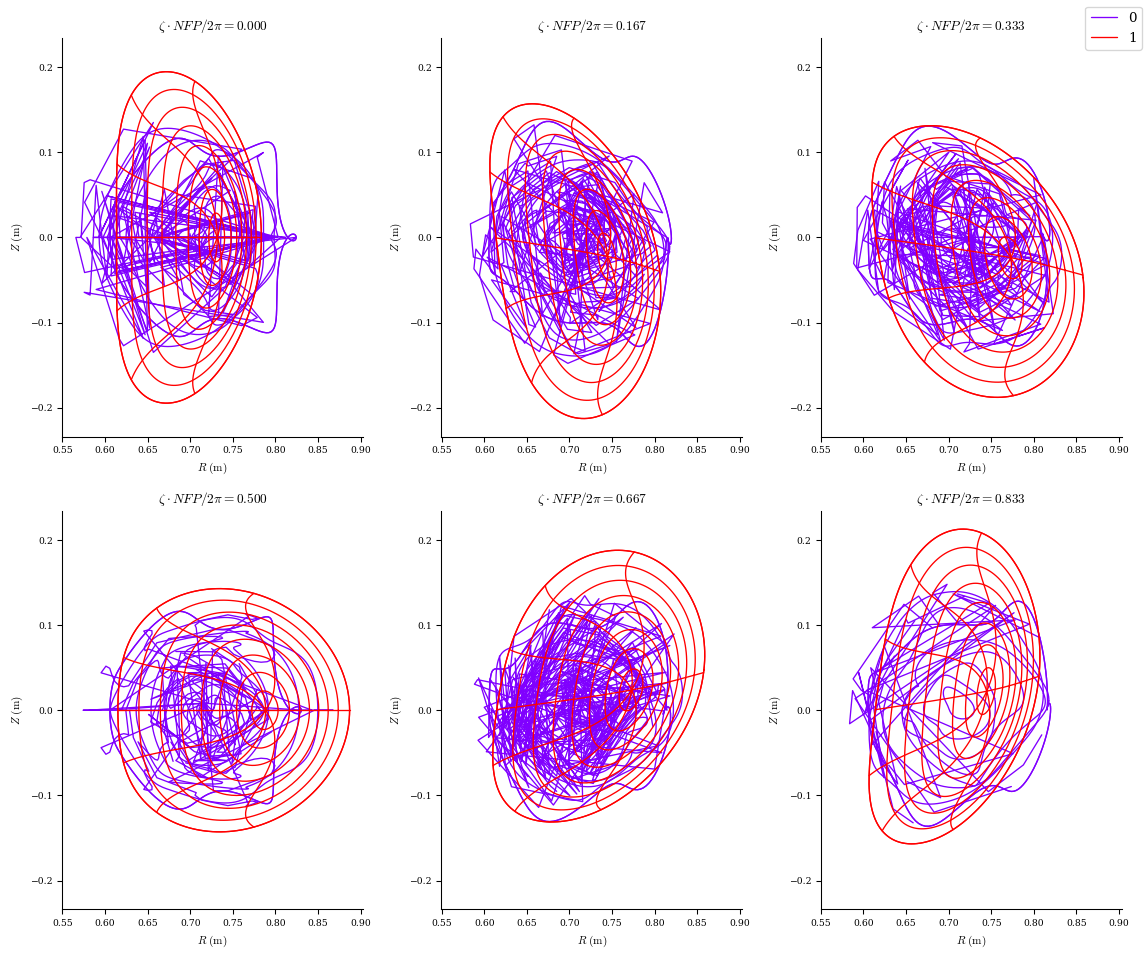

In [21]:
plot_comparison([eqs[-1]] + [veq]);

In [22]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

Perturbing Rb_lmn, Zb_lmn, IGphi_mn
Computing df
Timer: df computation = 19.5 sec
Computing dg
Timer: dg computation = 35.8 min
Factoring LHS
Timer: LHS factorization = 2.08 sec
Computing d^2f
Timer: d^2f computation = 301 ms
Computing d^2g
Timer: d^2g computation = 6.33 sec
||dc||/||c|| =  3.784e-04
||dx||/||x|| =  4.770e-03
Timer: Total perturbation = 36.8 min
Factorizing linear constraints
Starting optimization
Optimization terminated successfully.
`xtol` condition satisfied.
         Current function value: 3.563e+16
         Iterations: 2
         Function evaluations: 7
         Jacobian evaluations: 2
Start of solver
Total (sum of squares):  5.221e+16, 
Total force:  3.231e+08 (N)
End of solver
Total (sum of squares):  3.563e+16, 
Total force:  2.669e+08 (N)


In [23]:
print_error_summary(eqs)

Total force:  8.009e+07 (N)
Boundary Pressure Imbalance:  2.658e-02 Pa
Total force:  1.517e+13 (N)
Boundary Pressure Imbalance:  8.457e+03 Pa
Total force:  9.064e+12 (N)
Boundary Pressure Imbalance:  3.152e+00 Pa


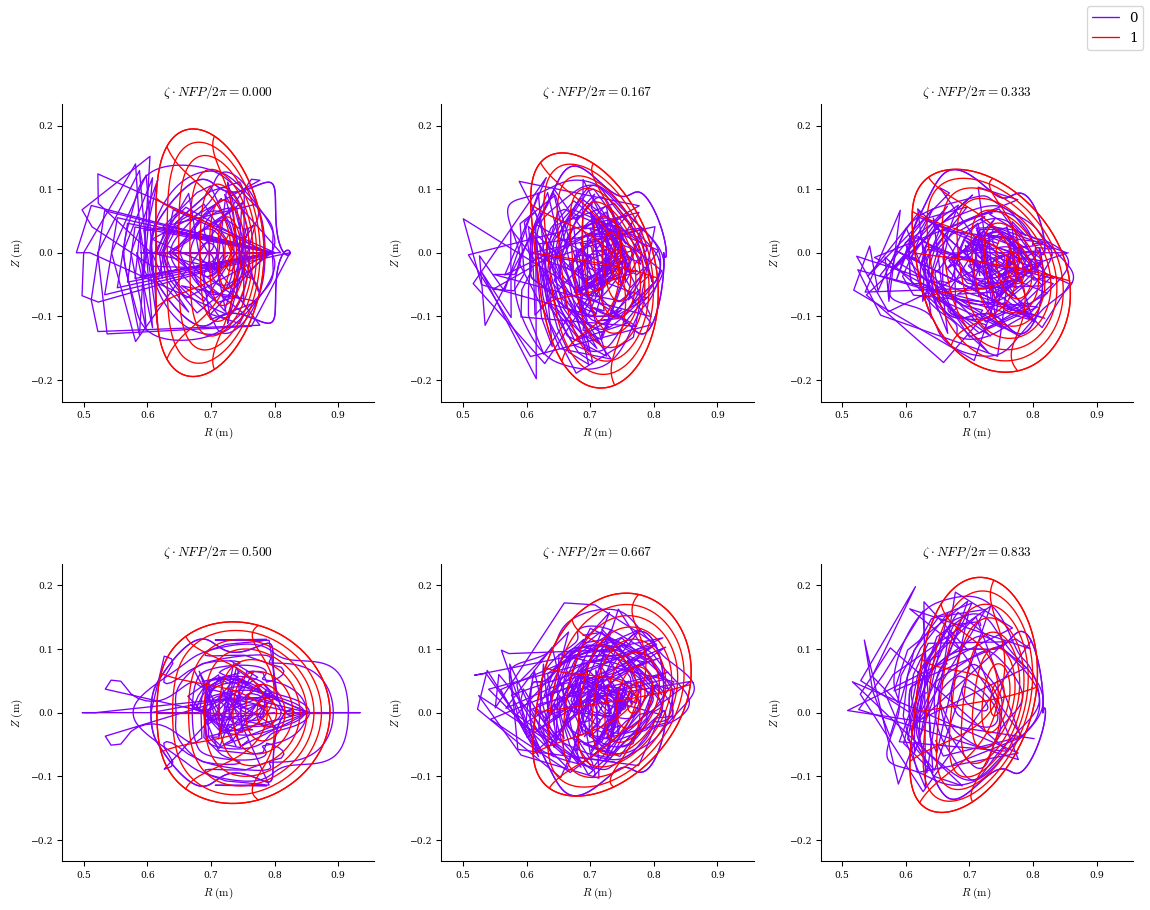

In [24]:
plot_comparison([eqs[-1]] + [veq]);

In [25]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

Perturbing Rb_lmn, Zb_lmn, IGphi_mn
Computing df
Timer: df computation = 22.0 sec
Computing dg
Timer: dg computation = 36.6 min
Factoring LHS
Timer: LHS factorization = 1.71 sec
Computing d^2f
Timer: d^2f computation = 304 ms
Computing d^2g
Timer: d^2g computation = 5.55 sec
||dc||/||c|| =  1.970e-06
||dx||/||x|| =  6.724e-07
Timer: Total perturbation = 37.6 min
Factorizing linear constraints
Starting optimization
Optimization terminated successfully.
`xtol` condition satisfied.
         Current function value: 2.977e+23
         Iterations: 1
         Function evaluations: 2
         Jacobian evaluations: 2
Start of solver
Total (sum of squares):  8.016e+27, 
Total force:  1.266e+14 (N)
End of solver
Total (sum of squares):  2.977e+23, 
Total force:  7.717e+11 (N)


In [26]:
print_error_summary(eqs)

Total force:  8.009e+07 (N)
Boundary Pressure Imbalance:  2.658e-02 Pa
Total force:  1.517e+13 (N)
Boundary Pressure Imbalance:  8.457e+03 Pa
Total force:  9.064e+12 (N)
Boundary Pressure Imbalance:  3.152e+00 Pa
Total force:  2.454e+17 (N)
Boundary Pressure Imbalance:  9.909e-01 Pa


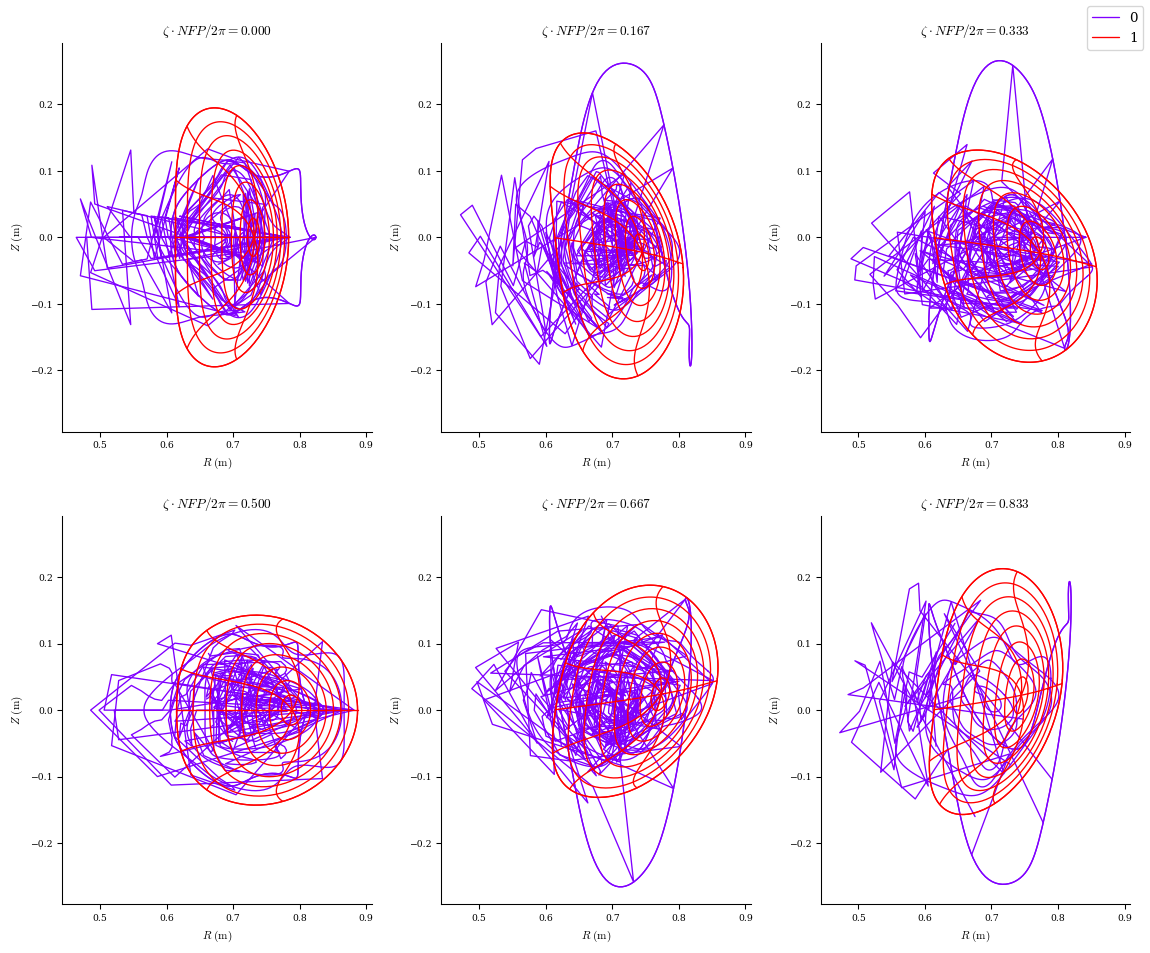

In [27]:
plot_comparison([eqs[-1]] + [veq]);

In [28]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

Perturbing Rb_lmn, Zb_lmn, IGphi_mn
Computing df
Timer: df computation = 21.7 sec
Computing dg
Timer: dg computation = 37.2 min
Factoring LHS
Timer: LHS factorization = 1.46 sec
Computing d^2f
Timer: d^2f computation = 360 ms
Computing d^2g
Timer: d^2g computation = 5.74 sec
||dc||/||c|| =  2.049e-06
||dx||/||x|| =  7.580e-08
Timer: Total perturbation = 38.2 min
Factorizing linear constraints
Starting optimization
Optimization terminated successfully.
`xtol` condition satisfied.
         Current function value: 2.151e+27
         Iterations: 1
         Function evaluations: 2
         Jacobian evaluations: 2
Start of solver
Total (sum of squares):  1.566e+20, 
Total force:  1.770e+10 (N)
End of solver
Total (sum of squares):  2.151e+27, 
Total force:  6.559e+13 (N)


In [29]:
print_error_summary(eqs)

Total force:  8.009e+07 (N)
Boundary Pressure Imbalance:  2.658e-02 Pa
Total force:  1.517e+13 (N)
Boundary Pressure Imbalance:  8.457e+03 Pa
Total force:  9.064e+12 (N)
Boundary Pressure Imbalance:  3.152e+00 Pa
Total force:  2.454e+17 (N)
Boundary Pressure Imbalance:  9.909e-01 Pa
Total force:  3.334e+17 (N)
Boundary Pressure Imbalance:  5.683e+01 Pa


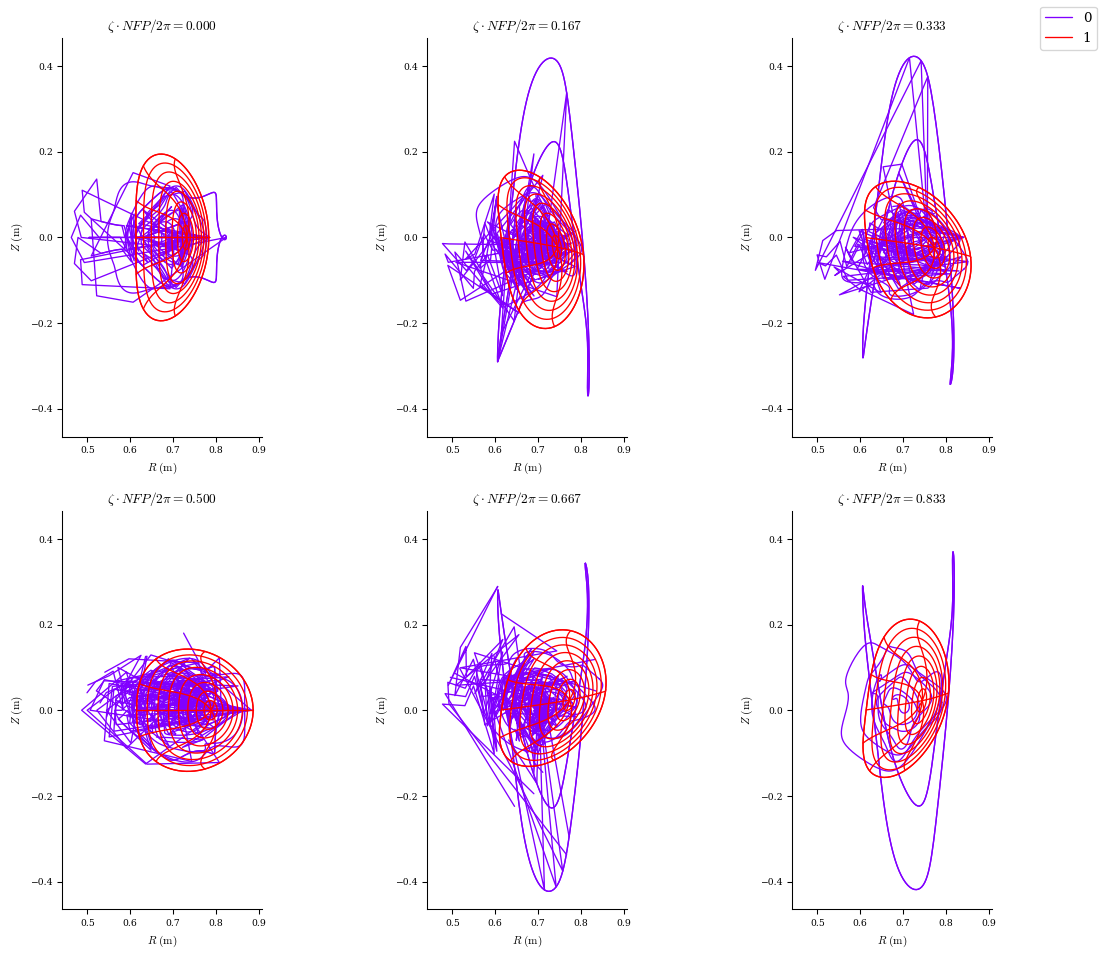

In [30]:
plot_comparison([eqs[-1]] + [veq]);

In [31]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

Perturbing Rb_lmn, Zb_lmn, IGphi_mn
Computing df
Timer: df computation = 21.3 sec
Computing dg
Timer: dg computation = 37.1 min
Factoring LHS
Timer: LHS factorization = 1.58 sec
Computing d^2f
Timer: d^2f computation = 203 ms
Computing d^2g
Timer: d^2g computation = 6.86 sec
||dc||/||c|| =  2.203e-06
||dx||/||x|| =  2.398e-07
Timer: Total perturbation = 38.0 min
Factorizing linear constraints
Starting optimization
Optimization terminated successfully.
`xtol` condition satisfied.
         Current function value: 5.595e+23
         Iterations: 1
         Function evaluations: 2
         Jacobian evaluations: 1
Start of solver
Total (sum of squares):  1.694e+19, 
Total force:  5.821e+09 (N)
End of solver
Total (sum of squares):  5.595e+23, 
Total force:  1.058e+12 (N)


In [32]:
print_error_summary(eqs)

Total force:  8.009e+07 (N)
Boundary Pressure Imbalance:  2.658e-02 Pa
Total force:  1.517e+13 (N)
Boundary Pressure Imbalance:  8.457e+03 Pa
Total force:  9.064e+12 (N)
Boundary Pressure Imbalance:  3.152e+00 Pa
Total force:  2.454e+17 (N)
Boundary Pressure Imbalance:  9.909e-01 Pa
Total force:  3.334e+17 (N)
Boundary Pressure Imbalance:  5.683e+01 Pa
Total force:  2.660e+15 (N)
Boundary Pressure Imbalance:  7.420e+03 Pa


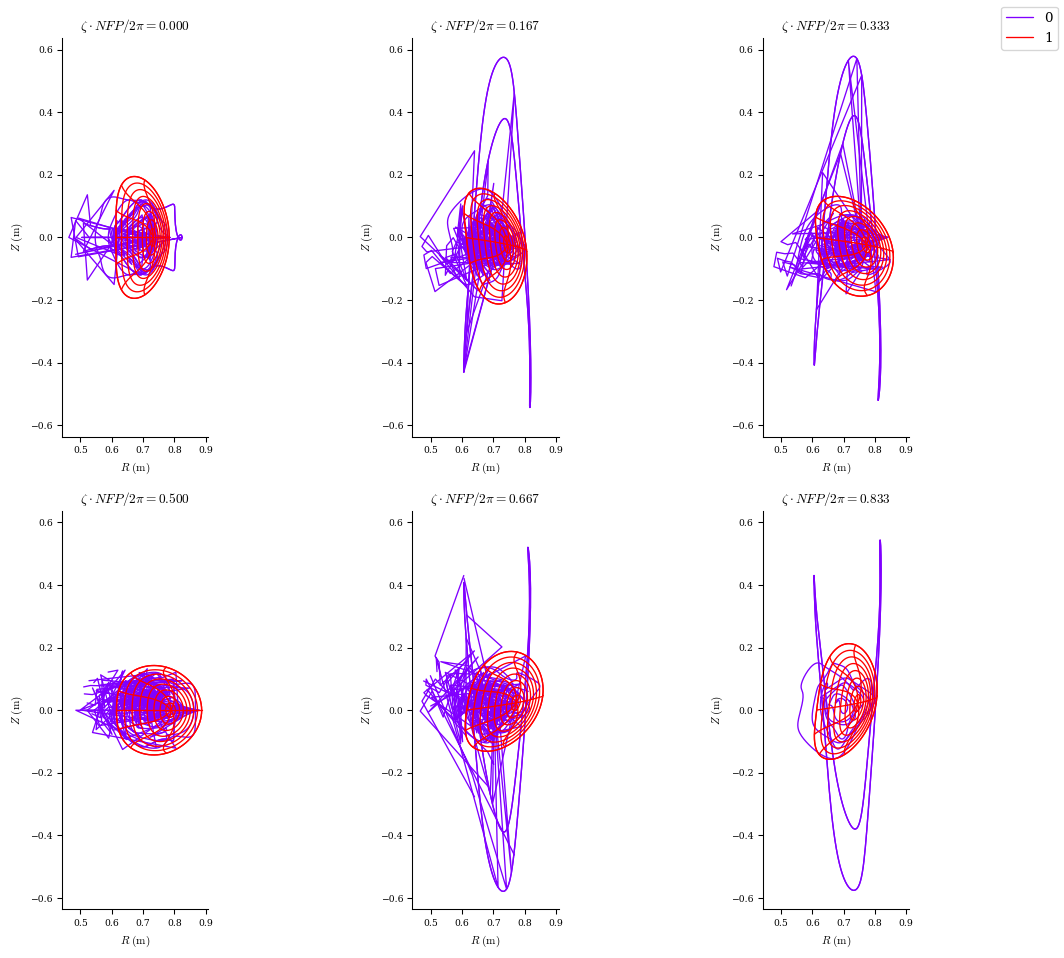

In [33]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

Perturbing Rb_lmn, Zb_lmn, IGphi_mn
Computing df
Timer: df computation = 20.9 sec
Computing dg


In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);

In [ ]:
eq_temp = optimal_perturb(
    eqs[-1],
    fb_objective1,
    bc_objective1,
    dRb=True,
    dZb=True,
    dIGphi=True,
    order=2,
    tr_ratio=[0.05, 0.05],
    verbose=3,
    copy=True,)
eqs.append(eq_temp[0])
eqs[-1].solve(objective=fb_objective1, maxiter=50);

In [ ]:
print_error_summary(eqs)

In [ ]:
plot_comparison([eqs[-1]] + [veq]);